In [2]:
!pip install mplsoccer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 577.0 kB/s eta 0:00:00


In [5]:
import pandas as pd
import json
from sqlalchemy import create_engine
import psycopg2
from mplsoccer import VerticalPitch,Pitch
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)

import os

In [6]:
from google.colab import drive, files
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [7]:
cd drive/MyDrive/Portfolio/

/content/drive/MyDrive/Portfolio


# Zirkzee
- Average position (Heatmap)
- Pass Map
- Shot Map

# Read JSON Data

In [ ]:
# Function to extract qualifiers into separate columns
def extract_qualifiers(df):
    # Initialize a list to hold all unique displayNames
    unique_display_names = set()

    # Iterate over each row in the qualifiers column to extract unique displayNames
    for item in df['qualifiers']:
        if isinstance(item, str):
            qualifiers_list = json.loads(item.replace("'", "\""))
            for qualifier in qualifiers_list:
                unique_display_names.add(qualifier['type']['displayName'])

    # Create a dictionary to hold the new columns data
    new_columns_data = {display_name: [] for display_name in unique_display_names}

    # Populate the new columns with corresponding values
    for item in df['qualifiers']:
        if isinstance(item, str):
            qualifiers_list = json.loads(item.replace("'", "\""))
            row_data = {display_name: None for display_name in unique_display_names}
            for qualifier in qualifiers_list:
                display_name = qualifier['type']['displayName']
                value = qualifier.get('value', None)
                row_data[display_name] = value
            for display_name in unique_display_names:
                new_columns_data[display_name].append(row_data[display_name])
        else:
            for display_name in unique_display_names:
                new_columns_data[display_name].append(None)

    # Create a new DataFrame from the new columns data
    new_columns_df = pd.DataFrame(new_columns_data)

    # Concatenate the new columns DataFrame with the original DataFrame
    df = pd.concat([df, new_columns_df], axis=1)

    return df


In [ ]:
#Read All events data
matchId = 1
player_list = pd.DataFrame()
events_all = pd.DataFrame()
for i in range(1,35):
    #Read json based on declared matcho
    read_json = open(f'whoscored_data/zirkzee_data/{i}.json', encoding="utf-8")

    #Load json data
    data = json.load(read_json)

    #Put json data on dataframe and normalize it
    events = pd.json_normalize(data['events'])

    #Add matchId data to differentiate between matches
    events['match_id']=matchId
    matchId = matchId + 1

    #append all events data into 1 dataframe
    events_all = pd.concat([events_all,events],ignore_index=True)

    #read player name and put into list
    player_name = pd.json_normalize(data['playerIdNameDictionary']).transpose()
    player_name = player_name.reset_index()
    player_name = player_name.rename(columns={"index":"playerId",
                                                0:"player_name",
                                            })
    player_name['playerId'] = player_name['playerId'].astype(int, errors = 'raise')
    player_list = pd.concat([player_list,player_name]).drop_duplicates().reset_index(drop=True)

#get player name into events data
events_all = events_all.merge(player_list,on=['playerId'],how='left')
events_all = events_all.rename(columns= {"eventId":"event_id",
                                        "teamId":"team_id",
                                        "playerId":"player_id",
                                        "expandedMinute":"expanded_minute",
                                        "satisfiedEventsTypes":"satisfied_events_types",
                                        "isTouch":"is_touch",
                                        "period.value":"period_value",
                                        "period.displayName":"period_display_name",
                                        "type.value":"type_value",
                                        "type.displayName":"type_display_name",
                                        "outcomeType.value":"outcome_type_value",
                                        "outcomeType.displayName":"outcome_type_display_name",
                                        "endX":"end_x",
                                        "endY":"end_y",
                                        "goalMouthZ":"goal_mouth_z",
                                        "goalMouthY":"goal_mouth_y",
                                        "isShot":"is_shot",
                                        "relatedEventId":"related_event_id",
                                        "relatedPlayerId":"related_player_id",
                                        "blockedX":"blocked_x",
                                        "blockedY":"blocked_y",
                                        "isGoal":"is_goal",
                                        "isOwnGoal":"is_own_goal",
                                        "cardType.value":"card_type_value",
                                        "cardtype_display_name":"card_type_display_name"
                                        })
events_all['qualifiers'] = events_all['qualifiers'].apply(json.dumps)
events_all = extract_qualifiers(events_all)
events_all = events_all.drop('qualifiers',axis=1)
events_all

,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcome_type_display_name,player_id,end_x,end_y,related_event_id,related_player_id,goal_mouth_z,goal_mouth_y,is_shot,blocked_x,blocked_y,is_goal,card_type_value,cardType.displayName,match_id,is_own_goal,player_name,OppositeRelatedEvent,OutfielderBlock,Volley,DeepBoxLeft,BoxCentre,Cross,FirstTouch,GoalMouthY,Blocked,PassEndX,Head,ThrowIn,GoalMouthZ,LowCentre,SmallBoxLeft,Throughball,HighRight,SecondYellow,Angle,LowRight,KeeperMissed,OwnGoal,Offensive,LeadingToGoal,SmallBoxCentre,LeftFoot,SetPiece,DirectFreekick,FormationSlot,KeeperSaveInSixYard,LowLeft,TeamFormation,TeamPlayerFormation,RightFoot,PlayerPosition,IntentionalGoalAssist,HighLeft,Defensive,BoxRight,LeadingToAttempt,LastMan,GoalKick,ThirtyFivePlusCentre,Longball,Feet,KeyPass,OneOnOne,KeeperWentWide,StandingSave,Red,DeepBoxRight,ShotAssist,Collected,RegularPlay,BlockedX,GoalDisallowed,DivingSave,BigChance,OtherBodyPart,AerialFoul,OutOfBoxLeft,CaptainPlayerId,Zone,Chipped,LayOff,ParriedDanger,MissHigh,Assisted,FastBreak,KeeperSaveInTheBox,IndividualPlay,PlayerCaughtOffside,ParriedSafe,InvolvedPlayers,OutOfBoxCentre,HeadPass,FromShotOffTarget,MissRight,FreekickTaken,RelatedEventId,FromCorner,MissLeft,SavedOffline,IntentionalAssist,OutOfBoxDeepLeft,OutOfBoxDeepRight,Foul,SixYardBlock,SmallBoxRight,HighClaim,BlockedY,HighCentre,Penalty,BigChanceCreated,CornerTaken,PassEndY,KeeperSaved,IndirectFreekickTaken,BoxLeft,Length,Obstruction,JerseyNumber,KeeperSaveObox,ThirtyFivePlusLeft,Hands,ThrowinSetPiece,BlockedCross,KeeperThrow,Yellow,OverRun,VoidYellowCard
0,2.580454e+09,2,0,0.0,80,0.0,0.0,0,[],False,1,FirstHalf,32,Start,1,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,2.580454e+09,2,0,0.0,71,0.0,0.0,0,[],False,1,FirstHalf,32,Start,1,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,2.580454e+09,3,0,0.0,71,49.5,49.5,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,383956.0,40.1,52.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Joshua Zirkzee,None,None,None,None,None,None,None,None,None,40.1,None,None,None,None,None,None,None,None,2.93,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Back,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,52.6,None,None,None,10.1,None,None,None,None,None,None,None,None,None,None,None
3,2.580454e+09,4,0,2.0,71,35.6,48.8,0,"[91, 117, 30, 35, 38, 215, 218]",True,1,FirstHalf,1,Pass,1,Successful,334653.0,25.3,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
events_all.to_csv('Zirkzee Data 2023-2024.csv')

In [8]:
events_all = pd.read_csv('Zirkzee Data 2023-2024.csv',index_col=0)
events_all

<ipython-input-8-4d1b9d8242a0>:1: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  events_all = pd.read_csv('Zirkzee Data 2023-2024.csv',index_col=0)


,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcome_type_display_name,player_id,end_x,end_y,related_event_id,related_player_id,goal_mouth_z,goal_mouth_y,is_shot,blocked_x,blocked_y,is_goal,card_type_value,cardType.displayName,match_id,is_own_goal,player_name,BlockedCross,Red,Blocked,GoalMouthZ,Foul,IntentionalGoalAssist,Assisted,FirstTouch,DivingSave,MissHigh,BoxRight,Longball,FreekickTaken,BoxCentre,KeeperSaveInTheBox,SmallBoxLeft,RelatedEventId,PassEndX,PassEndY,SecondYellow,HeadPass,KeeperSaved,KeeperMissed,LeftFoot,FormationSlot,JerseyNumber,PlayerCaughtOffside,LowRight,OtherBodyPart,Obstruction,OutOfBoxDeepRight,VoidYellowCard,RegularPlay,LayOff,LeadingToAttempt,KeeperThrow,ThirtyFivePlusLeft,Collected,BigChanceCreated,Hands,Angle,Feet,BoxLeft,BigChance,MissLeft,ParriedSafe,ThrowinSetPiece,OutOfBoxCentre,IndividualPlay,LowCentre,Head,ThrowIn,Throughball,GoalKick,Defensive,FromCorner,RightFoot,FromShotOffTarget,SixYardBlock,LastMan,OneOnOne,LowLeft,BlockedX,Volley,OutfielderBlock,OverRun,AerialFoul,SetPiece,OutOfBoxDeepLeft,Length,KeeperSaveInSixYard,MissRight,KeyPass,OutOfBoxLeft,Offensive,BlockedY,IntentionalAssist,KeeperWentWide,HighClaim,PlayerPosition,OppositeRelatedEvent,DeepBoxRight,HighLeft,Chipped,CornerTaken,CaptainPlayerId,DirectFreekick,SmallBoxRight,StandingSave,GoalDisallowed,HighCentre,HighRight,TeamPlayerFormation,Zone,IndirectFreekickTaken,DeepBoxLeft,ShotAssist,SavedOffline,ThirtyFivePlusCentre,ParriedDanger,LeadingToGoal,InvolvedPlayers,Yellow,Cross,SmallBoxCentre,GoalMouthY,FastBreak,OwnGoal,TeamFormation,Penalty,KeeperSaveObox
0,2.580454e+09,2,0,0.0,80,0.0,0.0,0,[],False,1,FirstHalf,32,Start,1,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.580454e+09,2,0,0.0,71,0.0,0.0,0,[],False,1,FirstHalf,32,Start,1,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.580454e+09,3,0,0.0,71,49.5,49.5,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,383956.0,40.1,52.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Joshua Zirkzee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.1,52.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.580454e+09,4,0,2.0,71,35.6,48.8,0,"[91, 117, 30, 35, 38, 215, 218]",True,1,FirstHalf,1,Pass,1,Successful,334653.0,25.3,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Nicolás Domínguez,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.3,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.8,NaN,NaN,NaN,Na

In [ ]:
events_all.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 53018 entries, 0 to 53017
Data columns (total 143 columns):
 #    Column                     Dtype  
---   ------                     -----  
 0    id                         float64
 1    event_id                   int64  
 2    minute                     int64  
 3    second                     float64
 4    team_id                    int64  
 5    x                          float64
 6    y                          float64
 7    expanded_minute            int64  
 8    satisfied_events_types     object 
 9    is_touch                   bool   
 10   period_value               int64  
 11   period_display_name        object 
 12   type_value                 int64  
 13   type_display_name          object 
 14   outcome_type_value         int64  
 15   outcome_type_display_name  object 
 16   player_id                  float64
 17   end_x                      float64
 18   end_y                      float64
 19   related_event_id           f

# First Match

In [ ]:
bologna_events = events_all.loc[events_all.team_id==71].reset_index(drop=True)
bologna_events

,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcome_type_display_name,player_id,end_x,end_y,related_event_id,related_player_id,goal_mouth_z,goal_mouth_y,is_shot,blocked_x,blocked_y,is_goal,card_type_value,cardType.displayName,match_id,is_own_goal,player_name,BlockedCross,Red,Blocked,GoalMouthZ,Foul,IntentionalGoalAssist,Assisted,FirstTouch,DivingSave,MissHigh,BoxRight,Longball,FreekickTaken,BoxCentre,KeeperSaveInTheBox,SmallBoxLeft,RelatedEventId,PassEndX,PassEndY,SecondYellow,HeadPass,KeeperSaved,KeeperMissed,LeftFoot,FormationSlot,JerseyNumber,PlayerCaughtOffside,LowRight,OtherBodyPart,Obstruction,OutOfBoxDeepRight,VoidYellowCard,RegularPlay,LayOff,LeadingToAttempt,KeeperThrow,ThirtyFivePlusLeft,Collected,BigChanceCreated,Hands,Angle,Feet,BoxLeft,BigChance,MissLeft,ParriedSafe,ThrowinSetPiece,OutOfBoxCentre,IndividualPlay,LowCentre,Head,ThrowIn,Throughball,GoalKick,Defensive,FromCorner,RightFoot,FromShotOffTarget,SixYardBlock,LastMan,OneOnOne,LowLeft,BlockedX,Volley,OutfielderBlock,OverRun,AerialFoul,SetPiece,OutOfBoxDeepLeft,Length,KeeperSaveInSixYard,MissRight,KeyPass,OutOfBoxLeft,Offensive,BlockedY,IntentionalAssist,KeeperWentWide,HighClaim,PlayerPosition,OppositeRelatedEvent,DeepBoxRight,HighLeft,Chipped,CornerTaken,CaptainPlayerId,DirectFreekick,SmallBoxRight,StandingSave,GoalDisallowed,HighCentre,HighRight,TeamPlayerFormation,Zone,IndirectFreekickTaken,DeepBoxLeft,ShotAssist,SavedOffline,ThirtyFivePlusCentre,ParriedDanger,LeadingToGoal,InvolvedPlayers,Yellow,Cross,SmallBoxCentre,GoalMouthY,FastBreak,OwnGoal,TeamFormation,Penalty,KeeperSaveObox
0,2.580454e+09,2,0,0.0,71,0.0,0.0,0,[],False,1,FirstHalf,32,Start,1,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.580454e+09,3,0,0.0,71,49.5,49.5,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,383956.0,40.1,52.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Joshua Zirkzee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.1,52.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.580454e+09,4,0,2.0,71,35.6,48.8,0,"[91, 117, 30, 35, 38, 215, 218]",True,1,FirstHalf,1,Pass,1,Successful,334653.0,25.3,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Nicolás Domínguez,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.3,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.580454e+09,5,0,4.0,71,25.3,26.5,0,"[91, 117, 30, 36, 38, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,422739.0,35.0,21.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Sam Beukema,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,21.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [ ]:
# Loop per match then update events all, so it wont have recipient between matches
for i in bologna_events.match_id.unique():
    each_match = bologna_events.loc[events_all.match_id==i]
    pass_success = each_match.loc[(each_match.type_display_name=='Pass') & (each_match.outcome_type_display_name=='Successful')]
    pass_success
    for j in pass_success.index:
        #print(j)
        bologna_events.loc[j, 'pass_recipient_name'] = each_match.iloc[i+1]['player_name']
        bologna_events.loc[j, 'pass_recipient_id'] = each_match.iloc[i+1]['player_id']
bologna_events

,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcome_type_display_name,player_id,end_x,end_y,related_event_id,related_player_id,goal_mouth_z,goal_mouth_y,is_shot,blocked_x,blocked_y,is_goal,card_type_value,cardType.displayName,match_id,is_own_goal,player_name,BlockedCross,Red,Blocked,GoalMouthZ,Foul,IntentionalGoalAssist,Assisted,FirstTouch,DivingSave,MissHigh,BoxRight,Longball,FreekickTaken,BoxCentre,KeeperSaveInTheBox,SmallBoxLeft,RelatedEventId,PassEndX,PassEndY,SecondYellow,HeadPass,KeeperSaved,KeeperMissed,LeftFoot,FormationSlot,JerseyNumber,PlayerCaughtOffside,LowRight,OtherBodyPart,Obstruction,OutOfBoxDeepRight,VoidYellowCard,RegularPlay,LayOff,LeadingToAttempt,KeeperThrow,ThirtyFivePlusLeft,Collected,BigChanceCreated,Hands,Angle,Feet,BoxLeft,BigChance,MissLeft,ParriedSafe,ThrowinSetPiece,OutOfBoxCentre,IndividualPlay,LowCentre,Head,ThrowIn,Throughball,GoalKick,Defensive,FromCorner,RightFoot,FromShotOffTarget,SixYardBlock,LastMan,OneOnOne,LowLeft,BlockedX,Volley,OutfielderBlock,OverRun,AerialFoul,SetPiece,OutOfBoxDeepLeft,Length,KeeperSaveInSixYard,MissRight,KeyPass,OutOfBoxLeft,Offensive,BlockedY,IntentionalAssist,KeeperWentWide,HighClaim,PlayerPosition,OppositeRelatedEvent,DeepBoxRight,HighLeft,Chipped,CornerTaken,CaptainPlayerId,DirectFreekick,SmallBoxRight,StandingSave,GoalDisallowed,HighCentre,HighRight,TeamPlayerFormation,Zone,IndirectFreekickTaken,DeepBoxLeft,ShotAssist,SavedOffline,ThirtyFivePlusCentre,ParriedDanger,LeadingToGoal,InvolvedPlayers,Yellow,Cross,SmallBoxCentre,GoalMouthY,FastBreak,OwnGoal,TeamFormation,Penalty,KeeperSaveObox,pass_recipient_name,pass_recipient_id
0,2.580454e+09,2,0,0.0,71,0.0,0.0,0,[],False,1,FirstHalf,32,Start,1,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.580454e+09,3,0,0.0,71,49.5,49.5,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,383956.0,40.1,52.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Joshua Zirkzee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.1,52.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nicolás Domínguez,334653.0
2,2.580454e+09,4,0,2.0,71,35.6,48.8,0,"[91, 117, 30, 35, 38, 215, 218]",True,1,FirstHalf,1,Pass,1,Successful,334653.0,25.3,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Nicolás Domínguez,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.3,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nicolás Domínguez,334653.0
3,2.580454e+09,5,0,4.0,71,25.3,26.5,0,"[91, 117, 30, 36, 38, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,422739.0,35.0,21.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Sam Beukema,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,21.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
bologna_events.to_csv('Zirkzee Data 2023-2024 Preprocessed.csv')

In [10]:
bologna_events = pd.read_csv('Zirkzee Data 2023-2024 Preprocessed.csv',index_col=0)
bologna_events

<ipython-input-10-7ecb052a1fef>:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  bologna_events = pd.read_csv('Zirkzee Data 2023-2024 Preprocessed.csv',index_col=0)


,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcome_type_display_name,player_id,end_x,end_y,related_event_id,related_player_id,goal_mouth_z,goal_mouth_y,is_shot,blocked_x,blocked_y,is_goal,card_type_value,cardType.displayName,match_id,is_own_goal,player_name,BlockedCross,Red,Blocked,GoalMouthZ,Foul,IntentionalGoalAssist,Assisted,FirstTouch,DivingSave,MissHigh,BoxRight,Longball,FreekickTaken,BoxCentre,KeeperSaveInTheBox,SmallBoxLeft,RelatedEventId,PassEndX,PassEndY,SecondYellow,HeadPass,KeeperSaved,KeeperMissed,LeftFoot,FormationSlot,JerseyNumber,PlayerCaughtOffside,LowRight,OtherBodyPart,Obstruction,OutOfBoxDeepRight,VoidYellowCard,RegularPlay,LayOff,LeadingToAttempt,KeeperThrow,ThirtyFivePlusLeft,Collected,BigChanceCreated,Hands,Angle,Feet,BoxLeft,BigChance,MissLeft,ParriedSafe,ThrowinSetPiece,OutOfBoxCentre,IndividualPlay,LowCentre,Head,ThrowIn,Throughball,GoalKick,Defensive,FromCorner,RightFoot,FromShotOffTarget,SixYardBlock,LastMan,OneOnOne,LowLeft,BlockedX,Volley,OutfielderBlock,OverRun,AerialFoul,SetPiece,OutOfBoxDeepLeft,Length,KeeperSaveInSixYard,MissRight,KeyPass,OutOfBoxLeft,Offensive,BlockedY,IntentionalAssist,KeeperWentWide,HighClaim,PlayerPosition,OppositeRelatedEvent,DeepBoxRight,HighLeft,Chipped,CornerTaken,CaptainPlayerId,DirectFreekick,SmallBoxRight,StandingSave,GoalDisallowed,HighCentre,HighRight,TeamPlayerFormation,Zone,IndirectFreekickTaken,DeepBoxLeft,ShotAssist,SavedOffline,ThirtyFivePlusCentre,ParriedDanger,LeadingToGoal,InvolvedPlayers,Yellow,Cross,SmallBoxCentre,GoalMouthY,FastBreak,OwnGoal,TeamFormation,Penalty,KeeperSaveObox,pass_recipient_name,pass_recipient_id
0,2.580454e+09,2,0,0.0,71,0.0,0.0,0,[],False,1,FirstHalf,32,Start,1,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.580454e+09,3,0,0.0,71,49.5,49.5,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,383956.0,40.1,52.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Joshua Zirkzee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.1,52.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nicolás Domínguez,334653.0
2,2.580454e+09,4,0,2.0,71,35.6,48.8,0,"[91, 117, 30, 35, 38, 215, 218]",True,1,FirstHalf,1,Pass,1,Successful,334653.0,25.3,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Nicolás Domínguez,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.3,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nicolás Domínguez,334653.0
3,2.580454e+09,5,0,4.0,71,25.3,26.5,0,"[91, 117, 30, 36, 38, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,422739.0,35.0,21.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Sam Beukema,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,21.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

## Plot Pass Map

In [ ]:
passing = bologna_events.loc[(bologna_events.player_name=='Joshua Zirkzee')&(bologna_events.type_display_name=='Pass')].reset_index(drop=True)
pass_success = passing.loc[passing.outcome_type_display_name=='Successful']
pass_fail = passing.loc[passing.outcome_type_display_name=='Unsuccessful']

In [ ]:
passing = bologna_events.loc[(bologna_events.player_name=='Joshua Zirkzee')&(bologna_events.type_display_name=='Pass')].reset_index(drop=True)
progressive_pass = passing.loc[passing.end_x>passing.x+1]
pass_success = passing.loc[passing.outcome_type_display_name=='Successful']
pass_fail = passing.loc[passing.outcome_type_display_name=='Unsuccessful']
progressive_pass_success = progressive_pass.loc[progressive_pass.outcome_type_display_name=='Successful']
progressive_pass_fail = progressive_pass.loc[progressive_pass.outcome_type_display_name=='Unsuccessful']

### Pass Map

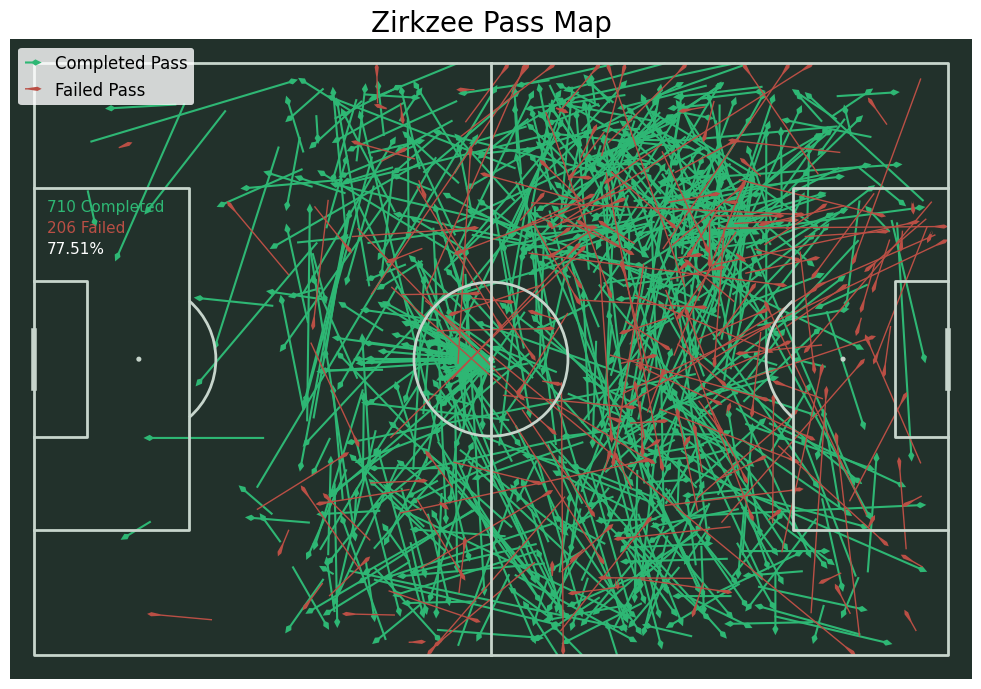

In [ ]:
# Set up the pitch
pass_success_count = len(pass_success.index)
pass_fail_count = len(pass_fail.index)
pass_rate = round(pass_success_count/(pass_success_count + pass_fail_count) *100,2)
pitch = Pitch(pitch_type='opta', half=False, line_zorder=2,pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(12, 7))
#fig.set_facecolor('#22312b')

# Plot the completed passes
pitch.arrows(pass_success.x, pass_success.y,
             pass_success.end_x, pass_success.end_y, width=1.5,
             headwidth=3, headlength=3, color='#2eb774', ax=ax, label='Completed Pass')

# Plot the other passes
pitch.arrows(pass_fail.x, pass_fail.y,
             pass_fail.end_x, pass_fail.end_y, width=1,
             headwidth=3, headlength=3, headaxislength=10,
             color='#ba4f45', ax=ax, label='Failed Pass')

# Set up the legend
ax.legend(facecolor='white', handlelength=1, edgecolor='None', fontsize=12, loc='upper left')
fig.text(0.13, 0.69, f'{pass_success_count} Completed', ha='left', va='baseline', fontsize=11, color='#2eb774')
fig.text(0.13, 0.66, f'{pass_fail_count} Failed', ha='left', va='baseline', fontsize=11, color='#ba4f45')
fig.text(0.13, 0.63, f'{pass_rate}%', ha='left', va='baseline', fontsize=11, color='white')
# Set the title
ax_title = ax.set_title(f'Zirkzee Pass Map', fontsize=20)

236

### Progressive Pass Map

Text(0.13, 0.63, '67.82%')

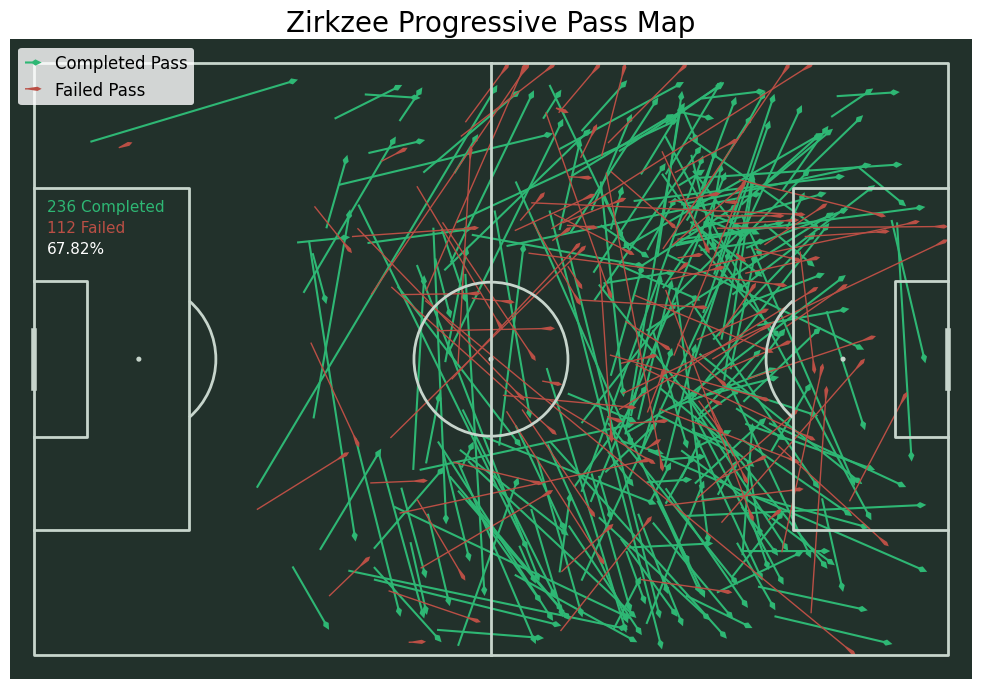

In [ ]:
# Set up the pitch
progressive_pass_success_count = len(progressive_pass_success.index)
progressive_pass_fail_count = len(progressive_pass_fail.index)
progressive_pass_rate = round(progressive_pass_success_count/(progressive_pass_success_count + progressive_pass_fail_count) *100,2)
pitch = Pitch(pitch_type='opta', half=False, line_zorder=2,pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(12, 7))
#fig.set_facecolor('#22312b')

# Plot the completed passes
pitch.arrows(progressive_pass_success.x, progressive_pass_success.y,
             progressive_pass_success.end_x, progressive_pass_success.end_y, width=1.5,
             headwidth=3, headlength=3, color='#2eb774', ax=ax, label='Completed Pass')

# Plot the other passes
pitch.arrows(progressive_pass_fail.x, progressive_pass_fail.y,
             progressive_pass_fail.end_x, progressive_pass_fail.end_y, width=1,
             headwidth=3, headlength=3, headaxislength=10,
             color='#ba4f45', ax=ax, label='Failed Pass')

# Set up the legend
ax.legend(facecolor='white', handlelength=1, edgecolor='None', fontsize=12, loc='upper left')

# Set the title
ax_title = ax.set_title(f'Zirkzee Progressive Pass Map', fontsize=20)
fig.text(0.13, 0.69, f'{progressive_pass_success_count} Completed', ha='left', va='baseline', fontsize=11, color='#2eb774')
fig.text(0.13, 0.66, f'{progressive_pass_fail_count} Failed', ha='left', va='baseline', fontsize=11, color='#ba4f45')
fig.text(0.13, 0.63, f'{progressive_pass_rate}%', ha='left', va='baseline', fontsize=11, color='white')
#ax.text(f'{len(progressive_pass_success.index)} Successful\n{len(progressive_pass_fail.index)} Unsuccessful')


## Plot Receive Pass

In [ ]:
receive_pass = bologna_events.loc[bologna_events.pass_recipient_name=='Joshua Zirkzee'].reset_index(drop=True)
receive_pass

,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcome_type_display_name,player_id,end_x,end_y,related_event_id,related_player_id,goal_mouth_z,goal_mouth_y,is_shot,blocked_x,blocked_y,is_goal,card_type_value,cardType.displayName,match_id,is_own_goal,player_name,BlockedCross,Red,Blocked,GoalMouthZ,Foul,IntentionalGoalAssist,Assisted,FirstTouch,DivingSave,MissHigh,BoxRight,Longball,FreekickTaken,BoxCentre,KeeperSaveInTheBox,SmallBoxLeft,RelatedEventId,PassEndX,PassEndY,SecondYellow,HeadPass,KeeperSaved,KeeperMissed,LeftFoot,FormationSlot,JerseyNumber,PlayerCaughtOffside,LowRight,OtherBodyPart,Obstruction,OutOfBoxDeepRight,VoidYellowCard,RegularPlay,LayOff,LeadingToAttempt,KeeperThrow,ThirtyFivePlusLeft,Collected,BigChanceCreated,Hands,Angle,Feet,BoxLeft,BigChance,MissLeft,ParriedSafe,ThrowinSetPiece,OutOfBoxCentre,IndividualPlay,LowCentre,Head,ThrowIn,Throughball,GoalKick,Defensive,FromCorner,RightFoot,FromShotOffTarget,SixYardBlock,LastMan,OneOnOne,LowLeft,BlockedX,Volley,OutfielderBlock,OverRun,AerialFoul,SetPiece,OutOfBoxDeepLeft,Length,KeeperSaveInSixYard,MissRight,KeyPass,OutOfBoxLeft,Offensive,BlockedY,IntentionalAssist,KeeperWentWide,HighClaim,PlayerPosition,OppositeRelatedEvent,DeepBoxRight,HighLeft,Chipped,CornerTaken,CaptainPlayerId,DirectFreekick,SmallBoxRight,StandingSave,GoalDisallowed,HighCentre,HighRight,TeamPlayerFormation,Zone,IndirectFreekickTaken,DeepBoxLeft,ShotAssist,SavedOffline,ThirtyFivePlusCentre,ParriedDanger,LeadingToGoal,InvolvedPlayers,Yellow,Cross,SmallBoxCentre,GoalMouthY,FastBreak,OwnGoal,TeamFormation,Penalty,KeeperSaveObox,pass_recipient_name,pass_recipient_id
0,2.654517e+09,521,49,13.0,71,20.8,90.0,50,"[91, 117, 30, 35, 38, 215, 218]",True,2,SecondHalf,1,Pass,1,Successful,365308.0,19.5,69.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,NaN,Alexis Saelemaekers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.5,69.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Joshua Zirkzee,383956.0
1,2.654517e+09,522,49,14.0,71,19.5,69.9,50,"[91, 117, 30, 35, 37, 215, 218]",True,2,SecondHalf,1,Pass,1,Successful,386519.0,5.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,NaN,Riccardo Calafiori,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Joshua Zirkzee,383956.0
2,2.654517e+09,523,49,17.0,71,5.3,81.3,50,"[91, 117, 30, 124, 36, 37, 215, 218]",True,2,SecondHalf,1,Pass,1,Successful,416970.0,31.9,84.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,NaN,Victor Kristiansen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.9,84.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Joshua Zirkzee,383956.0
3,2.654517e+09,526,49,21.0,71,35.3,83.6,50,"[91, 117, 30, 124, 36, 38, 216, 218]",True,2,SecondHalf,1,Pass,1,Successful,386519.0,36.6,70.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,NaN,Riccardo Calafiori,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

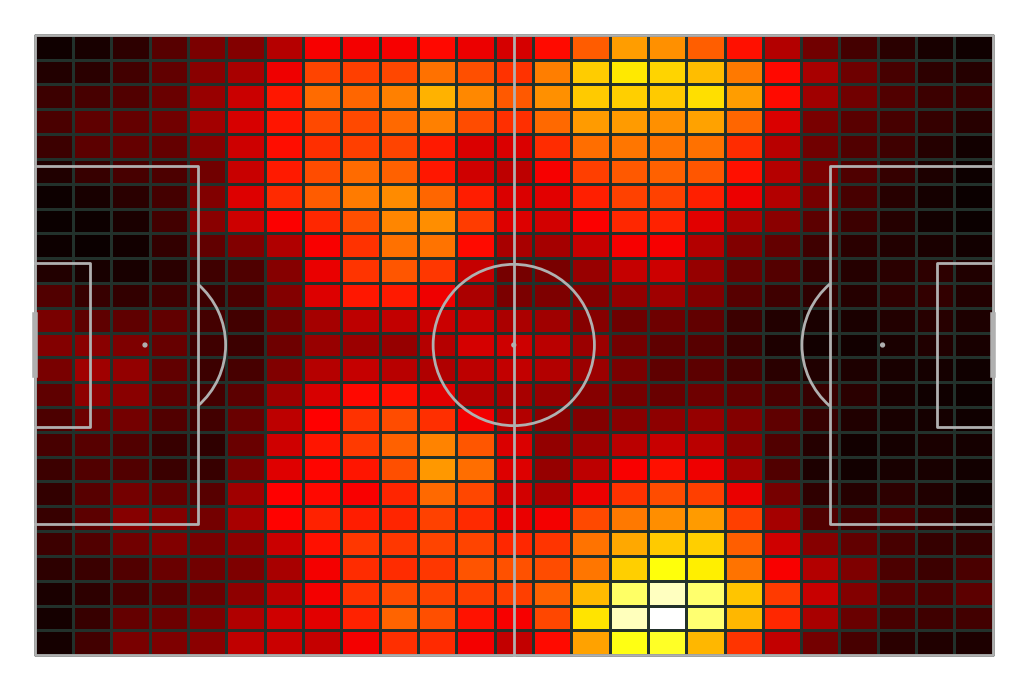

In [ ]:
from scipy.ndimage import gaussian_filter

pitch = Pitch(pitch_type='opta', half=False, line_zorder=2)
fig, ax = pitch.draw(figsize=(12, 7))
bin_statistic = pitch.bin_statistic(receive_pass.end_x, receive_pass.end_y, statistic='count', bins=(25, 25))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pitch.heatmap(bin_statistic, ax=ax, cmap='hot', edgecolors='#22312b')
#pitch.heatmap(receive_pass.end_x, receive_pass.end_y, s=30, c = 'Green', ax=ax,edgecolors="black")

#ax.title('Shot')
plt.show()

# Zirkzee Shots

In [ ]:
events_zirkzee = bologna_events.loc[bologna_events.player_id==383956].reset_index(drop=True)
events_zirkzee

,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcome_type_display_name,player_id,end_x,end_y,related_event_id,related_player_id,goal_mouth_z,goal_mouth_y,is_shot,blocked_x,blocked_y,is_goal,card_type_value,cardType.displayName,match_id,is_own_goal,player_name,BlockedCross,Red,Blocked,GoalMouthZ,Foul,IntentionalGoalAssist,Assisted,FirstTouch,DivingSave,MissHigh,BoxRight,Longball,FreekickTaken,BoxCentre,KeeperSaveInTheBox,SmallBoxLeft,RelatedEventId,PassEndX,PassEndY,SecondYellow,HeadPass,KeeperSaved,KeeperMissed,LeftFoot,FormationSlot,JerseyNumber,PlayerCaughtOffside,LowRight,OtherBodyPart,Obstruction,OutOfBoxDeepRight,VoidYellowCard,RegularPlay,LayOff,LeadingToAttempt,KeeperThrow,ThirtyFivePlusLeft,Collected,BigChanceCreated,Hands,Angle,Feet,BoxLeft,BigChance,MissLeft,ParriedSafe,ThrowinSetPiece,OutOfBoxCentre,IndividualPlay,LowCentre,Head,ThrowIn,Throughball,GoalKick,Defensive,FromCorner,RightFoot,FromShotOffTarget,SixYardBlock,LastMan,OneOnOne,LowLeft,BlockedX,Volley,OutfielderBlock,OverRun,AerialFoul,SetPiece,OutOfBoxDeepLeft,Length,KeeperSaveInSixYard,MissRight,KeyPass,OutOfBoxLeft,Offensive,BlockedY,IntentionalAssist,KeeperWentWide,HighClaim,PlayerPosition,OppositeRelatedEvent,DeepBoxRight,HighLeft,Chipped,CornerTaken,CaptainPlayerId,DirectFreekick,SmallBoxRight,StandingSave,GoalDisallowed,HighCentre,HighRight,TeamPlayerFormation,Zone,IndirectFreekickTaken,DeepBoxLeft,ShotAssist,SavedOffline,ThirtyFivePlusCentre,ParriedDanger,LeadingToGoal,InvolvedPlayers,Yellow,Cross,SmallBoxCentre,GoalMouthY,FastBreak,OwnGoal,TeamFormation,Penalty,KeeperSaveObox,pass_recipient_name,pass_recipient_id
0,2.580454e+09,3,0,0.0,71,49.5,49.5,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,383956.0,40.1,52.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Joshua Zirkzee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.1,52.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nicolás Domínguez,334653.0
1,2.580458e+09,61,8,37.0,71,44.3,32.3,8,"[91, 101, 56]",True,1,FirstHalf,8,Interception,1,Successful,383956.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Joshua Zirkzee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.580459e+09,83,12,7.0,71,50.0,50.0,12,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,383956.0,41.1,56.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Joshua Zirkzee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.1,56.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nicolás Domínguez,334653.0
3,2.580460e+09,97,12,30.0,71,46.5,84.3,12,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,383956.0,41.5,97.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Joshua Zirkzee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.5,97.0,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:
zirkzee_shots = events_zirkzee.loc[events_zirkzee['period_display_name']!='PenaltyShootout'].reset_index(drop=True)
zirkzee_goal = zirkzee_shots.loc[zirkzee_shots['type_display_name']=="Goal"].reset_index(drop=True)
zirkzee_saved_shot = zirkzee_shots.loc[zirkzee_shots['type_display_name']=="SavedShot"].reset_index(drop=True)
zirkzee_missed_shot = zirkzee_shots.loc[zirkzee_shots['type_display_name']=="MissedShots"].reset_index(drop=True)


Text(0.3, 0.6, '12.79% Conversion Rate')

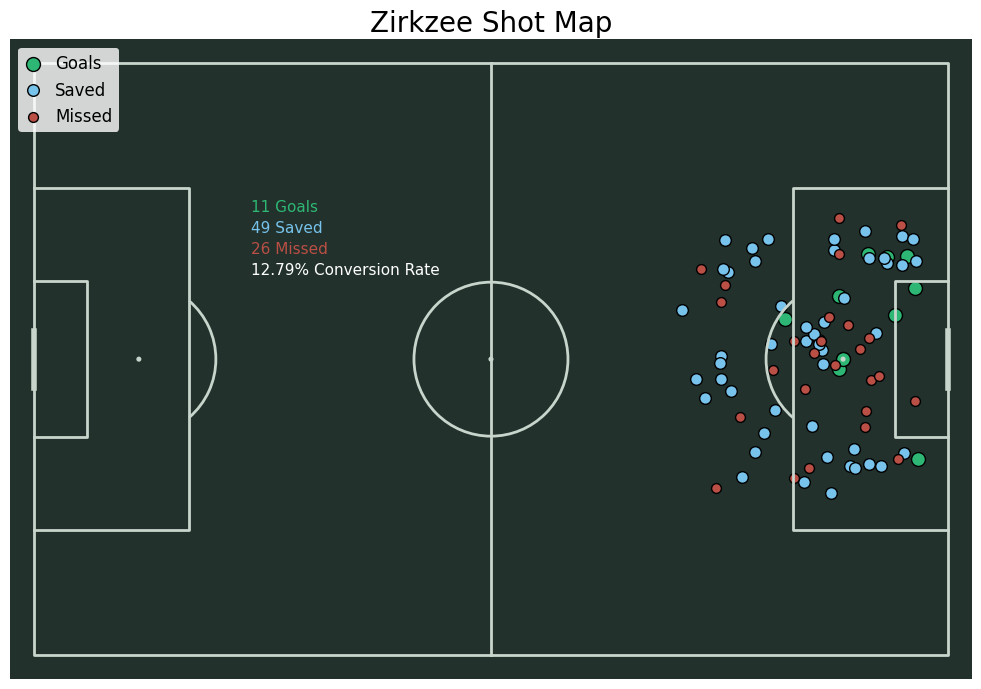

In [ ]:
# Set up the pitch
zirkzee_goal_count = len(zirkzee_goal.index)
zirkzee_saved_shot_count = len(zirkzee_saved_shot.index)
zirkzee_missed_shot_count = len(zirkzee_missed_shot.index)
zirkzee_shots_count = zirkzee_goal_count + zirkzee_saved_shot_count + zirkzee_missed_shot_count
shot_rate = round(zirkzee_goal_count/zirkzee_shots_count *100,2)
pitch = Pitch(pitch_type='opta', half=False, line_zorder=2,pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(12, 7))
#fig.set_facecolor('#22312b')


pitch.scatter(zirkzee_missed_shot.x, zirkzee_missed_shot.y, s=50, c = '#ba4f45', ax=ax,edgecolors="black",label='Missed')
pitch.scatter(zirkzee_saved_shot.x, zirkzee_saved_shot.y, s=70, c = '#77c3ec', ax=ax,edgecolors="black",label='Saved')
pitch.scatter(zirkzee_goal.x, zirkzee_goal.y, s=100, c = '#2eb774', ax=ax,edgecolors="black",label='Goals')

# Set up the legend
ax.legend(facecolor='white', handlelength=1, edgecolor='None', fontsize=12, loc='upper left')

# Set the title
ax_title = ax.set_title(f'Zirkzee Shot Map', fontsize=20)
fig.text(0.3, 0.69, f'{zirkzee_goal_count} Goals', ha='left', va='baseline', fontsize=11, color='#2eb774')
fig.text(0.3, 0.66, f'{zirkzee_saved_shot_count} Saved', ha='left', va='baseline', fontsize=11, color='#77c3ec')
fig.text(0.3, 0.63, f'{zirkzee_missed_shot_count} Missed', ha='left', va='baseline', fontsize=11, color='#ba4f45')
fig.text(0.3, 0.60, f'{shot_rate}% Conversion Rate', ha='left', va='baseline', fontsize=11, color='white')
#ax.text(f'{len(progressive_pass_success.index)} Successful\n{len(progressive_pass_fail.index)} Unsuccessful')


# Hojlund

In [16]:
mu_events = pd.read_csv('Manchester United Events 2023-2024 Preprocessed.csv',index_col=0)
mu_events

<ipython-input-16-b7be54528f02>:1: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  mu_events = pd.read_csv('Manchester United Events 2023-2024 Preprocessed.csv',index_col=0)


,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcome_type_display_name,player_id,end_x,end_y,related_event_id,related_player_id,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type_value,cardType.displayName,is_goal,match_id,is_own_goal,player_name,Cross,JerseyNumber,RelatedEventId,Offensive,Throughball,LeadingToAttempt,KeyPass,IndirectFreekickTaken,LowCentre,TeamFormation,IntentionalGoalAssist,GoalMouthY,OutOfBoxDeepRight,VoidYellowCard,MissLeft,Assisted,OneOnOne,FormationSlot,PenaltyShootoutConcededGK,Volley,BigChance,FromShotOffTarget,OtherBodyPart,DeepBoxLeft,BoxLeft,FreekickTaken,Chipped,PlayerPosition,KeeperThrow,DeepBoxRight,StandingSave,Feet,Longball,CornerTaken,FastBreak,KeeperWentWide,BlockedY,HighRight,RegularPlay,KeeperSaveInSixYard,Penalty,Head,OutfielderBlock,KeeperMissed,PassEndX,MissHigh,HeadPass,PassEndY,BlockedX,KeeperSaved,SmallBoxRight,Blocked,IntentionalAssist,BoxCentre,Defensive,OutOfBoxCentre,Foul,BigChanceCreated,LayOff,ThrowIn,Collected,BoxRight,OutOfBoxDeepLeft,FirstTouch,Red,GoalKick,ShotAssist,GoalMouthZ,Hands,HighLeft,KeeperSaveInTheBox,Length,ParriedSafe,ThirtyFivePlusCentre,SmallBoxCentre,SavedOffline,PlayerCaughtOffside,BlockedCross,LowRight,LeftFoot,Yellow,SecondYellow,RightFoot,OutOfBoxRight,OppositeRelatedEvent,OwnGoal,KeeperSaveObox,LastMan,HighCentre,ParriedDanger,HighClaim,SetPiece,Zone,FromCorner,SmallBoxLeft,AerialFoul,OverRun,LowLeft,ThirtyFivePlusLeft,DirectFreekick,Angle,MissRight,DivingSave,ThrowinSetPiece,GoalDisallowed,CaptainPlayerId,TeamPlayerFormation,SixYardBlock,InvolvedPlayers,LeadingToGoal,IndividualPlay,pass_recipient_name,pass_recipient_id
0,2.577368e+09,2,0,0.0,32,0.0,0.0,0,[],False,1,FirstHalf,32,Start,1,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.577368e+09,3,0,0.0,32,49.9,49.9,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,123761.0,37.0,50.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Bruno Fernandes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,NaN,NaN,50.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Casemiro,88526.0
2,2.577368e+09,4,0,2.0,32,37.0,50.1,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,88526.0,35.7,83.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Casemiro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.7,NaN,NaN,83.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Casemiro,88526.0
3,2.577368e+09,5,0,3.0,32,35.7,83.6,0,"[91, 117, 30, 35, 38, 215, 218]",True,1,FirstHalf,1,Pass,1,Successful,118244.0,29.7,67.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Luke Shaw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [17]:
mu_events.player_name.unique()

array([nan, 'Bruno Fernandes', 'Casemiro', 'Luke Shaw',
       'Lisandro Martínez', 'André Onana', 'Aaron Wan-Bissaka',
       'Raphaël Varane', 'Mason Mount', 'Alejandro Garnacho', 'Antony',
       'Marcus Rashford', 'Victor Lindelöf', 'Christian Eriksen',
       'Jadon Sancho', 'Facundo Pellistri', 'Scott McTominay',
       'Diogo Dalot', 'Anthony Martial', 'Rasmus Højlund',
       'Harry Maguire', 'Jonny Evans', 'Sergio Reguilón',
       'Hannibal Mejbri', 'Sofyan Amrabat', 'Daniel Gore',
       'Donny van de Beek', 'Kobbie Mainoo', 'Willy Kambwala',
       'Amad Diallo', 'Omari Forson', 'Altay Bayindir', 'Ethan Wheatley'],
      dtype=object)

## Plot Pass Map

In [18]:
passing = mu_events.loc[(mu_events.player_name=='Rasmus Højlund')&(mu_events.type_display_name=='Pass')].reset_index(drop=True)
progressive_pass = passing.loc[passing.end_x>passing.x+1]
pass_success = passing.loc[passing.outcome_type_display_name=='Successful']
pass_fail = passing.loc[passing.outcome_type_display_name=='Unsuccessful']
progressive_pass_success = progressive_pass.loc[progressive_pass.outcome_type_display_name=='Successful']
progressive_pass_fail = progressive_pass.loc[progressive_pass.outcome_type_display_name=='Unsuccessful']

### Pass Map

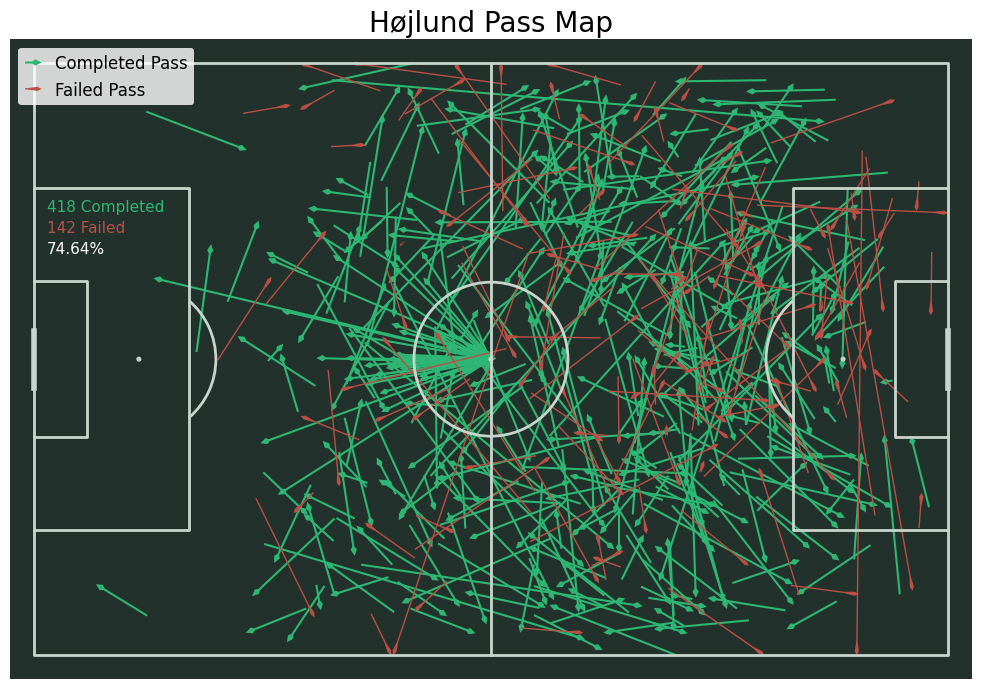

In [19]:
# Set up the pitch
pass_success_count = len(pass_success.index)
pass_fail_count = len(pass_fail.index)
pass_rate = round(pass_success_count/(pass_success_count + pass_fail_count) *100,2)
pitch = Pitch(pitch_type='opta', half=False, line_zorder=2,pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(12, 7))
#fig.set_facecolor('#22312b')

# Plot the completed passes
pitch.arrows(pass_success.x, pass_success.y,
             pass_success.end_x, pass_success.end_y, width=1.5,
             headwidth=3, headlength=3, color='#2eb774', ax=ax, label='Completed Pass')

# Plot the other passes
pitch.arrows(pass_fail.x, pass_fail.y,
             pass_fail.end_x, pass_fail.end_y, width=1,
             headwidth=3, headlength=3, headaxislength=10,
             color='#ba4f45', ax=ax, label='Failed Pass')

# Set up the legend
ax.legend(facecolor='white', handlelength=1, edgecolor='None', fontsize=12, loc='upper left')
fig.text(0.13, 0.69, f'{pass_success_count} Completed', ha='left', va='baseline', fontsize=11, color='#2eb774')
fig.text(0.13, 0.66, f'{pass_fail_count} Failed', ha='left', va='baseline', fontsize=11, color='#ba4f45')
fig.text(0.13, 0.63, f'{pass_rate}%', ha='left', va='baseline', fontsize=11, color='white')
# Set the title
ax_title = ax.set_title(f'Højlund Pass Map', fontsize=20)

### Progressive Pass Map

Text(0.13, 0.63, '67.29%')

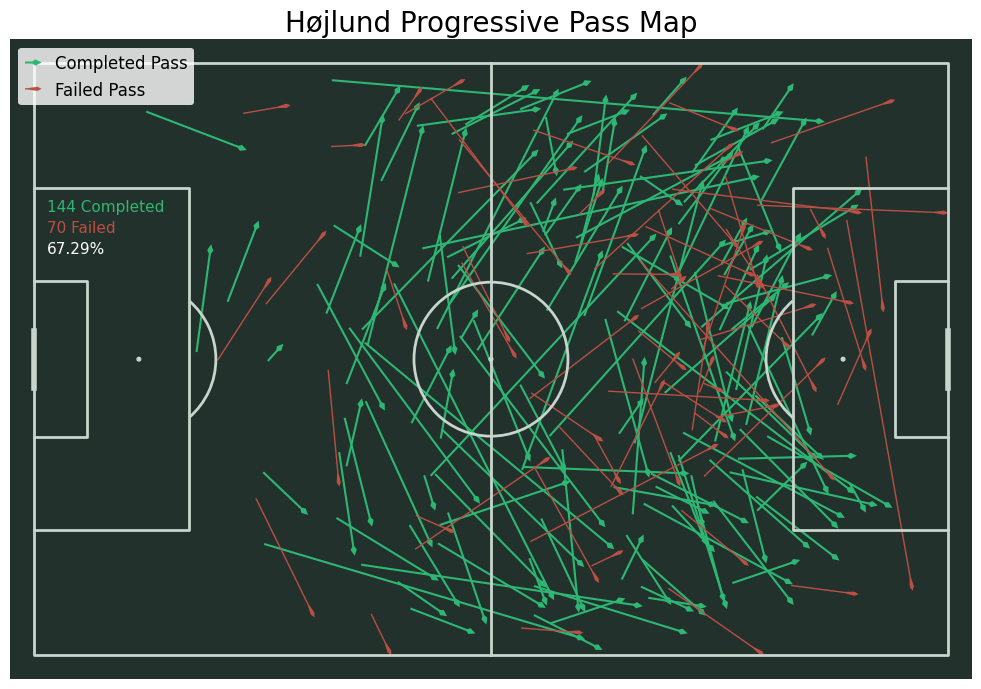

In [20]:
# Set up the pitch
progressive_pass_success_count = len(progressive_pass_success.index)
progressive_pass_fail_count = len(progressive_pass_fail.index)
progressive_pass_rate = round(progressive_pass_success_count/(progressive_pass_success_count + progressive_pass_fail_count) *100,2)
pitch = Pitch(pitch_type='opta', half=False, line_zorder=2,pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(12, 7))
#fig.set_facecolor('#22312b')

# Plot the completed passes
pitch.arrows(progressive_pass_success.x, progressive_pass_success.y,
             progressive_pass_success.end_x, progressive_pass_success.end_y, width=1.5,
             headwidth=3, headlength=3, color='#2eb774', ax=ax, label='Completed Pass')

# Plot the other passes
pitch.arrows(progressive_pass_fail.x, progressive_pass_fail.y,
             progressive_pass_fail.end_x, progressive_pass_fail.end_y, width=1,
             headwidth=3, headlength=3, headaxislength=10,
             color='#ba4f45', ax=ax, label='Failed Pass')

# Set up the legend
ax.legend(facecolor='white', handlelength=1, edgecolor='None', fontsize=12, loc='upper left')

# Set the title
ax_title = ax.set_title(f'Højlund Progressive Pass Map', fontsize=20)
fig.text(0.13, 0.69, f'{progressive_pass_success_count} Completed', ha='left', va='baseline', fontsize=11, color='#2eb774')
fig.text(0.13, 0.66, f'{progressive_pass_fail_count} Failed', ha='left', va='baseline', fontsize=11, color='#ba4f45')
fig.text(0.13, 0.63, f'{progressive_pass_rate}%', ha='left', va='baseline', fontsize=11, color='white')
#ax.text(f'{len(progressive_pass_success.index)} Successful\n{len(progressive_pass_fail.index)} Unsuccessful')


## Plot Receive Pass

In [21]:
receive_pass = mu_events.loc[mu_events.pass_recipient_name=='Rasmus Højlund'].reset_index(drop=True)
receive_pass

,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcome_type_display_name,player_id,end_x,end_y,related_event_id,related_player_id,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type_value,cardType.displayName,is_goal,match_id,is_own_goal,player_name,Cross,JerseyNumber,RelatedEventId,Offensive,Throughball,LeadingToAttempt,KeyPass,IndirectFreekickTaken,LowCentre,TeamFormation,IntentionalGoalAssist,GoalMouthY,OutOfBoxDeepRight,VoidYellowCard,MissLeft,Assisted,OneOnOne,FormationSlot,PenaltyShootoutConcededGK,Volley,BigChance,FromShotOffTarget,OtherBodyPart,DeepBoxLeft,BoxLeft,FreekickTaken,Chipped,PlayerPosition,KeeperThrow,DeepBoxRight,StandingSave,Feet,Longball,CornerTaken,FastBreak,KeeperWentWide,BlockedY,HighRight,RegularPlay,KeeperSaveInSixYard,Penalty,Head,OutfielderBlock,KeeperMissed,PassEndX,MissHigh,HeadPass,PassEndY,BlockedX,KeeperSaved,SmallBoxRight,Blocked,IntentionalAssist,BoxCentre,Defensive,OutOfBoxCentre,Foul,BigChanceCreated,LayOff,ThrowIn,Collected,BoxRight,OutOfBoxDeepLeft,FirstTouch,Red,GoalKick,ShotAssist,GoalMouthZ,Hands,HighLeft,KeeperSaveInTheBox,Length,ParriedSafe,ThirtyFivePlusCentre,SmallBoxCentre,SavedOffline,PlayerCaughtOffside,BlockedCross,LowRight,LeftFoot,Yellow,SecondYellow,RightFoot,OutOfBoxRight,OppositeRelatedEvent,OwnGoal,KeeperSaveObox,LastMan,HighCentre,ParriedDanger,HighClaim,SetPiece,Zone,FromCorner,SmallBoxLeft,AerialFoul,OverRun,LowLeft,ThirtyFivePlusLeft,DirectFreekick,Angle,MissRight,DivingSave,ThrowinSetPiece,GoalDisallowed,CaptainPlayerId,TeamPlayerFormation,SixYardBlock,InvolvedPlayers,LeadingToGoal,IndividualPlay,pass_recipient_name,pass_recipient_id
0,2.593947e+09,232,28,55.0,32,23.5,65.0,28,"[91, 117, 30, 36, 38, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,22079.0,37.1,52.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,Jonny Evans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.1,NaN,NaN,52.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rasmus Højlund,439584.0
1,2.593947e+09,236,29,8.0,32,74.8,42.8,29,"[91, 119, 117, 30, 205, 35, 37, 217, 218]",True,1,FirstHalf,1,Pass,1,Successful,439584.0,69.5,51.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,Rasmus Højlund,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.5,NaN,NaN,51.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rasmus Højlund,439584.0
2,2.593947e+09,237,29,10.0,32,69.5,51.6,29,"[91, 119, 117, 30, 205, 35, 37, 217, 218]",True,1,FirstHalf,1,Pass,1,Successful,88526.0,68.4,67.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,Casemiro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.4,NaN,NaN,67.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rasmus Højlund,439584.0
3,2.593947e+09,238,29,12.0,32,68.7,68.0,29,"[91, 119, 117, 30, 205, 36, 37, 217, 218]",True,1,FirstHalf,1,Pass,1,Successful,362275.0,76.2,86.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,Sergio Reguilón,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

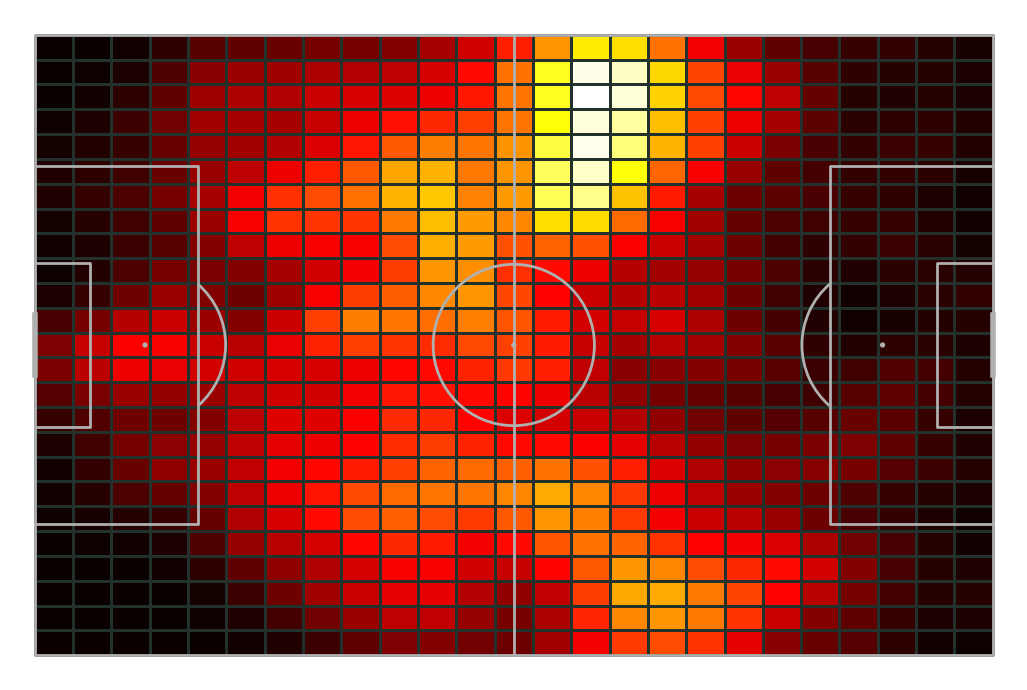

In [22]:
from scipy.ndimage import gaussian_filter

pitch = Pitch(pitch_type='opta', half=False, line_zorder=2)
fig, ax = pitch.draw(figsize=(12, 7))
bin_statistic = pitch.bin_statistic(receive_pass.end_x, receive_pass.end_y, statistic='count', bins=(25, 25))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pitch.heatmap(bin_statistic, ax=ax, cmap='hot', edgecolors='#22312b')
#pitch.heatmap(receive_pass.end_x, receive_pass.end_y, s=30, c = 'Green', ax=ax,edgecolors="black")

#ax.title('Shot')
plt.show()

## Hojlund Shots

In [23]:
events_hojlund = mu_events.loc[mu_events.player_name=='Rasmus Højlund'].reset_index(drop=True)
events_hojlund

,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcome_type_display_name,player_id,end_x,end_y,related_event_id,related_player_id,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type_value,cardType.displayName,is_goal,match_id,is_own_goal,player_name,Cross,JerseyNumber,RelatedEventId,Offensive,Throughball,LeadingToAttempt,KeyPass,IndirectFreekickTaken,LowCentre,TeamFormation,IntentionalGoalAssist,GoalMouthY,OutOfBoxDeepRight,VoidYellowCard,MissLeft,Assisted,OneOnOne,FormationSlot,PenaltyShootoutConcededGK,Volley,BigChance,FromShotOffTarget,OtherBodyPart,DeepBoxLeft,BoxLeft,FreekickTaken,Chipped,PlayerPosition,KeeperThrow,DeepBoxRight,StandingSave,Feet,Longball,CornerTaken,FastBreak,KeeperWentWide,BlockedY,HighRight,RegularPlay,KeeperSaveInSixYard,Penalty,Head,OutfielderBlock,KeeperMissed,PassEndX,MissHigh,HeadPass,PassEndY,BlockedX,KeeperSaved,SmallBoxRight,Blocked,IntentionalAssist,BoxCentre,Defensive,OutOfBoxCentre,Foul,BigChanceCreated,LayOff,ThrowIn,Collected,BoxRight,OutOfBoxDeepLeft,FirstTouch,Red,GoalKick,ShotAssist,GoalMouthZ,Hands,HighLeft,KeeperSaveInTheBox,Length,ParriedSafe,ThirtyFivePlusCentre,SmallBoxCentre,SavedOffline,PlayerCaughtOffside,BlockedCross,LowRight,LeftFoot,Yellow,SecondYellow,RightFoot,OutOfBoxRight,OppositeRelatedEvent,OwnGoal,KeeperSaveObox,LastMan,HighCentre,ParriedDanger,HighClaim,SetPiece,Zone,FromCorner,SmallBoxLeft,AerialFoul,OverRun,LowLeft,ThirtyFivePlusLeft,DirectFreekick,Angle,MissRight,DivingSave,ThrowinSetPiece,GoalDisallowed,CaptainPlayerId,TeamPlayerFormation,SixYardBlock,InvolvedPlayers,LeadingToGoal,IndividualPlay,pass_recipient_name,pass_recipient_id
0,2.586507e+09,586,66,22.0,32,0.0,0.0,70,[213],False,2,SecondHalf,19,SubstitutionOn,1,Successful,439584.0,NaN,NaN,585.0,122366.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,Rasmus Højlund,NaN,11,585.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.586509e+09,598,69,42.0,32,72.5,19.1,73,"[91, 69]",True,2,SecondHalf,61,BallTouch,0,Unsuccessful,439584.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,Rasmus Højlund,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Right,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.586510e+09,601,70,19.0,32,91.0,31.2,74,[64],False,2,SecondHalf,4,Foul,0,Unsuccessful,439584.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,Rasmus Højlund,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,616.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.586511e+09,620,71,30.0,32,95.3,52.8,75,"[91, 10, 140, 0, 3, 11, 13]",True,2,SecondHalf,15,SavedShot,1,Successful,439584.0,NaN,NaN,619.0,300299.0,95.9,52.3,19.0,49.2,True,NaN,NaN,NaN,4,NaN,Rasmus Højlund,NaN,NaN,619.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [24]:
hojlund_shots = events_hojlund.loc[events_hojlund['period_display_name']!='PenaltyShootout'].reset_index(drop=True)
hojlund_goal = hojlund_shots.loc[hojlund_shots['type_display_name']=="Goal"].reset_index(drop=True)
hojlund_saved_shot = hojlund_shots.loc[hojlund_shots['type_display_name']=="SavedShot"].reset_index(drop=True)
hojlund_missed_shot = hojlund_shots.loc[hojlund_shots['type_display_name']=="MissedShots"].reset_index(drop=True)


Text(0.3, 0.6, '28.57% Conversion Rate')

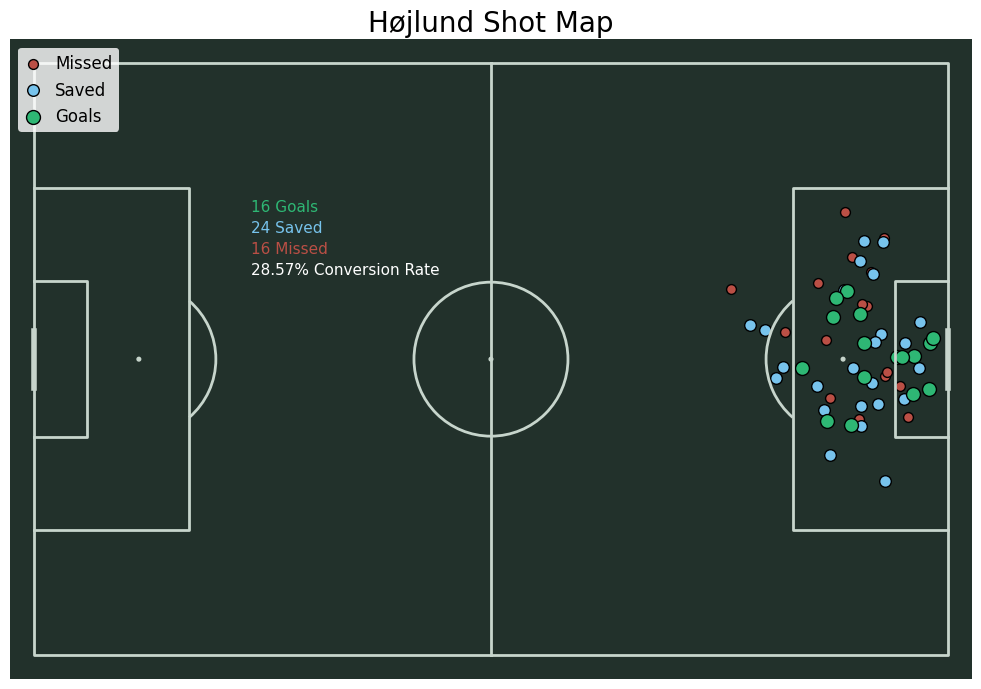

In [27]:
# Set up the pitch
hojlund_goal_count = len(hojlund_goal.index)
hojlund_saved_shot_count = len(hojlund_saved_shot.index)
hojlund_missed_shot_count = len(hojlund_missed_shot.index)
hojlund_shots_count = hojlund_goal_count + hojlund_saved_shot_count + hojlund_missed_shot_count
shot_rate = round(hojlund_goal_count/hojlund_shots_count *100,2)
pitch = Pitch(pitch_type='opta', half=False, line_zorder=2,pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(12, 7))
#fig.set_facecolor('#22312b')


pitch.scatter(hojlund_missed_shot.x, hojlund_missed_shot.y, s=50, c = '#ba4f45', ax=ax,edgecolors="black",label='Missed')
pitch.scatter(hojlund_saved_shot.x, hojlund_saved_shot.y, s=70, c = '#77c3ec', ax=ax,edgecolors="black",label='Saved')
pitch.scatter(hojlund_goal.x, hojlund_goal.y, s=100, c = '#2eb774', ax=ax,edgecolors="black",label='Goals')

# Set up the legend
ax.legend(facecolor='white', handlelength=1, edgecolor='None', fontsize=12, loc='upper left')

# Set the title
ax_title = ax.set_title(f'Højlund Shot Map', fontsize=20)
fig.text(0.3, 0.69, f'{hojlund_goal_count} Goals', ha='left', va='baseline', fontsize=11, color='#2eb774')
fig.text(0.3, 0.66, f'{hojlund_saved_shot_count} Saved', ha='left', va='baseline', fontsize=11, color='#77c3ec')
fig.text(0.3, 0.63, f'{hojlund_missed_shot_count} Missed', ha='left', va='baseline', fontsize=11, color='#ba4f45')
fig.text(0.3, 0.60, f'{shot_rate}% Conversion Rate', ha='left', va='baseline', fontsize=11, color='white')
#ax.text(f'{len(progressive_pass_success.index)} Successful\n{len(progressive_pass_fail.index)} Unsuccessful')
